# TRADING CUANTITATIVO

#### CONTEXTO

- Mercado: EUR/USD
- Timeframe: 1H
- Descarga de datos (3 años)
- Features sin fuga (“solo velas cerradas”)
- Target (próxima vela)
- Validación temporal + walk-forward opcional
- Modelo baseline + Gradient Boosting
- Backtest más realista con costos (spread + comisión + slippage)
- Métricas de trading (equity, CAGR aprox, max drawdown, Sharpe aprox)

>**Nota:** Esto es para aprender el pipeline. No es consejo financiero.

## 0) Instalación

In [2]:
!pip install yfinance pandas numpy scikit-learn matplotlib



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: C:\Users\TRENDINGPC\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import sys
!{sys.executable} -m pip install yfinance


In [3]:
import yfinance as yf


## 1) Descargar datos EURUSD 1H (3 años)

In [4]:

import yfinance as yf
import pandas as pd

symbol = "EURUSD=X"
df = yf.download(symbol, period="730d", interval="1h", auto_adjust=False, progress=False)

# yfinance a veces devuelve columnas MultiIndex cuando hay tickers
df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
df = df.rename(columns=str.lower).dropna().copy()

df.head(), df.tail(), df.shape


(                           adj close     close      high       low      open  \
 Datetime                                                                       
 2023-04-18 23:00:00+00:00   1.098056  1.098056  1.098298  1.097695  1.097695   
 2023-04-19 00:00:00+00:00   1.098539  1.098539  1.098901  1.097815  1.098056   
 2023-04-19 01:00:00+00:00   1.097093  1.097093  1.098780  1.097093  1.098539   
 2023-04-19 02:00:00+00:00   1.097695  1.097695  1.097936  1.096852  1.097093   
 2023-04-19 03:00:00+00:00   1.097695  1.097695  1.098056  1.097333  1.097695   
 
                            volume  
 Datetime                           
 2023-04-18 23:00:00+00:00       0  
 2023-04-19 00:00:00+00:00       0  
 2023-04-19 01:00:00+00:00       0  
 2023-04-19 02:00:00+00:00       0  
 2023-04-19 03:00:00+00:00       0  ,
                            adj close     close      high       low      open  \
 Datetime                                                                       
 2026-02-

## 2) Limpieza básica + checks

In [6]:
# Quitar velas inválidas (muy raro, pero buena práctica)
df = df[(df["high"] >= df["low"]) & (df["close"] > 0)].copy()

# Asegura índice datetime y orden
df = df.sort_index()
df.index = pd.to_datetime(df.index)

df.isna().sum()


adj close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

In [7]:
# Verificando que el DataFrame no esté vacío
if df.empty:
    raise ValueError("El DataFrame está vacío después de la limpieza de datos.")    
df.head(), df.tail(), df.shape
df.info()
df.describe()
df.index.min(), df.index.max()
df.index.freq  # None porque hay huecos en los datos
df = df.asfreq('H')  # Reindexa con frecuencia horaria
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17264 entries, 2023-04-18 23:00:00+00:00 to 2026-02-03 10:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   adj close  17264 non-null  float64
 1   close      17264 non-null  float64
 2   high       17264 non-null  float64
 3   low        17264 non-null  float64
 4   open       17264 non-null  float64
 5   volume     17264 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 944.1 KB


C:\Users\TRENDINGPC\AppData\Local\Temp\ipykernel_2768\2343294818.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')  # Reindexa con frecuencia horaria


adj close    7252
close        7252
high         7252
low          7252
open         7252
volume       7252
dtype: int64

## 3) Features (solo con información pasada)

#### Estas features son “clásicas” y seguras para empezar.

In [8]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    d = data.copy()

    # Retornos
    d["ret_1"]  = d["close"].pct_change(1)
    d["ret_3"]  = d["close"].pct_change(3)
    d["ret_6"]  = d["close"].pct_change(6)
    d["ret_12"] = d["close"].pct_change(12)
    d["ret_24"] = d["close"].pct_change(24)

    # Medias
    d["sma_10"] = d["close"].rolling(10).mean()
    d["sma_30"] = d["close"].rolling(30).mean()
    d["sma_ratio"] = d["sma_10"] / d["sma_30"] - 1

    # Volatilidad rolling
    d["vol_20"] = d["ret_1"].rolling(20).std()

    # Rango relativo (proxy ATR simple)
    d["range"] = (d["high"] - d["low"]) / d["close"]

    # Velas (cuerpo y mechas) - normalizadas
    d["body"] = (d["close"] - d["open"]) / d["close"]
    d["upper_wick"] = (d["high"] - d[["close","open"]].max(axis=1)) / d["close"]
    d["lower_wick"] = (d[["close","open"]].min(axis=1) - d["low"]) / d["close"]

    return d

df_feat = add_features(df)
df_feat = df_feat.dropna().copy()
df_feat.head()


C:\Users\TRENDINGPC\AppData\Local\Temp\ipykernel_2768\3869259806.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  d["ret_1"]  = d["close"].pct_change(1)
C:\Users\TRENDINGPC\AppData\Local\Temp\ipykernel_2768\3869259806.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  d["ret_3"]  = d["close"].pct_change(3)
C:\Users\TRENDINGPC\AppData\Local\Temp\ipykernel_2768\3869259806.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None'

,adj close,close,high,low,open,volume,ret_1,ret_3,ret_6,ret_12,ret_24,sma_10,sma_30,sma_ratio,vol_20,range,body,upper_wick,lower_wick
Datetime,,,,,,,,,,,,,,,,,,,
2023-04-20 04:00:00+00:00,1.096251,1.096251,1.096371,1.095890,1.096251,0.0,0.000000,-0.000109,0.000439,-0.000548,-0.000877,1.095975,1.096096,-0.000111,0.000814,0.000438,0.000000,0.000110,0.000329
2023-04-20 05:00:00+00:00,1.096491,1.096491,1.096972,1.095890,1.096371,0.0,0.000219,0.000767,0.000877,0.000548,0.000110,1.096047,1.096044,0.000003,0.000606,0.000987,0.000110,0.000439,0.000438
2023-04-20 06:00:00+00:00,1.096972,1.096972,1.097574,1.096371,1.096491,0.0,0.000439,0.000658,0.000878,0.001316,0.000987,1.096131,1.095991,0.000127,0.000609,0.001097,0.000439,0.000549,0.000110
2023-04-20 07:00:00+00:00,1.096491,1.096491,1.097213,1.095530,1.096972,0.0,-0.000439,0.000219,0.000110,0.000658,-0.000110,1.096179,1.095971,0.000189,0.000621,0.001535,-0.000439,0.000220,0.000876
2023-04-20 08:00:00+00:00,1.097695,1.097695,1.098056,1.096011,1.096011,0.0,0.001098,0.001098,0.001866,0.001427,0.001647,1.096371,1.095971,0.000365,0.000560,0.001864,0.001534,0.000329,0.000000


## 4) Target: dirección de la próxima vela (t+1)

In [ ]:
# 4) Target: 3 clases para la próxima vela (t+1)
#   1  = UP   (sube más que una zona muerta)
#   0  = FLAT (movimiento pequeño / ruido)
#  -1  = DOWN (baja más que una zona muerta)

pip = 0.0001
deadzone_pips = 1.5          # AJUSTA esto luego (ej: 1.0, 1.5, 2.0...)
dead = deadzone_pips * pip

# Retorno forward (t -> t+1) en términos relativos
fwd_ret = df_feat["close"].shift(-1) / df_feat["close"] - 1

# Target 3-clases
df_feat["target"] = 0  # FLAT por defecto
df_feat.loc[fwd_ret >  dead, "target"] = 1    # UP
df_feat.loc[fwd_ret < -dead, "target"] = -1   # DOWN

# Quitamos última fila (no tiene target) y cualquier NaN residual
df_feat = df_feat.dropna().copy()

feature_cols = [
    "ret_1","ret_3","ret_6","ret_12","ret_24",
    "sma_ratio","vol_20","range",
    "body","upper_wick","lower_wick"
]

X = df_feat[feature_cols]
y = df_feat["target"]

X.shape, y.value_counts(normalize=True).sort_index()



((12848, 11),
 target
 0    0.541018
 1    0.458982
 Name: proportion, dtype: float64)

## 5) Split temporal (train/val/test)

In [ ]:
# Split temporal: train/val/test (70/10/20)
n = len(df_feat)
train_end = int(n * 0.70)
val_end   = int(n * 0.80)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

df_train = df_feat.iloc[:train_end].copy()
df_val   = df_feat.iloc[train_end:val_end].copy()
df_test  = df_feat.iloc[val_end:].copy()

(X_train.shape, X_val.shape, X_test.shape), y_train.value_counts().sort_index()


LogReg AUC: 0.5264180264180264
              precision    recall  f1-score   support

           0       0.55      0.97      0.70      1404
           1       0.52      0.04      0.07      1166

    accuracy                           0.55      2570
   macro avg       0.54      0.50      0.39      2570
weighted avg       0.54      0.55      0.42      2570



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

proba_val = gb.predict_proba(X_val)
proba_test = gb.predict_proba(X_test)
classes = gb.classes_

print("Clases:", classes)
print("proba_val shape:", proba_val.shape, "proba_test shape:", proba_test.shape)


In [ ]:
Celda 4 → Target + X, y
Celda 5 → (A) Split train / val / test
Celda 6 → (B) Entrenamiento (solo TRAIN) + proba_val / proba_test
Celda 7 → (C) Funciones auxiliares (señal + métricas)
Celda 8 → (D/E) Grid search de thresholds en VALIDATION
Celda 9 → (F/G) Test final


#### Ahora Gradient Boosting (suele funcionar muy bien como primer “modelo serio” sin libs extra):

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

proba_gb = gb.predict_proba(X_test)[:, 1]
pred_gb = (proba_gb >= 0.5).astype(int)

print("GB AUC:", roc_auc_score(y_test, proba_gb))
print(classification_report(y_test, pred_gb))


GB AUC: 0.529899869522511
              precision    recall  f1-score   support

           0       0.55      0.84      0.67      1404
           1       0.48      0.18      0.26      1166

    accuracy                           0.54      2570
   macro avg       0.52      0.51      0.46      2570
weighted avg       0.52      0.54      0.48      2570



## 5.1 Convertir probabilidades multiclase -> señal de clase (-1, 0, 1)

In [ ]:
# 5.5) Convertir probabilidades multiclase -> señal de clase (-1, 0, 1)

import numpy as np
import pandas as pd

# index del set de test para alinear señal con precios
df_test = df_feat.iloc[split:].copy()

# Asegura orden de clases
# classes suele ser [-1, 0, 1], pero NO lo asumas: lo obtenemos
idx_down = np.where(classes == -1)[0][0]
idx_flat = np.where(classes ==  0)[0][0]
idx_up   = np.where(classes ==  1)[0][0]

# Thresholds de "confianza" (ajustables)
th_up = 0.45
th_down = 0.45

# Señal inicial: todo FLAT
signal = np.zeros(len(proba_gb), dtype=int)

# Activar UP o DOWN solo si la probabilidad supera el umbral
signal[proba_gb[:, idx_up] >= th_up] = 1
signal[proba_gb[:, idx_down] >= th_down] = -1

# Si (raro) cumple ambos, elige el más probable
both = (proba_gb[:, idx_up] >= th_up) & (proba_gb[:, idx_down] >= th_down)
signal[both] = np.where(proba_gb[both, idx_up] > proba_gb[both, idx_down], 1, -1)

# Serie alineada con el índice del test
signal_series = pd.Series(signal, index=df_test.index)

signal_series.value_counts(normalize=True).sort_index()


## 6) Backtest con costos (spread + comisión + slippage)

#### Supuestos de costos (ajustables)

- **spread_pips:** spread promedio en pips (EURUSD típico 0.6–1.5 pips en broker decente)
- **slippage_pips:** Deslizamiento promedio por entrada/salida
- **commission_per_round_turn:** comisión por ida y vuelta (si aplica). En FX retail a veces viene “embebida” en spread (pon 0).

>1 pip en EURUSD = 0.0001 (aprox).

Costos se aplican **cuando cambias de posición** (trade).
La función recibe **posiciones** (la señal) directamente


In [ ]:
def backtest_from_signal(
    prices: pd.Series,
    signal: pd.Series,
    spread_pips: float = 1.0,
    slippage_pips: float = 0.2,
    commission_round_turn: float = 0.0
):
    """
    signal: Serie con valores -1 (short), 0 (flat), +1 (long)
    Ejecuta sobre el retorno de la siguiente vela (t->t+1).
    Costos se aplican cuando cambia la posición.
    """
    df_bt = pd.DataFrame({"close": prices, "pos": signal}).copy()

    # Retorno forward (t->t+1)
    df_bt["fwd_ret"] = df_bt["close"].pct_change().shift(-1)

    # Trades = cambio de posición
    df_bt["pos_prev"] = df_bt["pos"].shift(1).fillna(0)
    df_bt["trade"] = (df_bt["pos"] != df_bt["pos_prev"]).astype(int)

    # Costos en retorno
    pip_value = 0.0001
    total_pips = spread_pips + slippage_pips
    df_bt["cost_ret"] = df_bt["trade"] * (total_pips * pip_value) / df_bt["close"]
    df_bt["commission_ret"] = df_bt["trade"] * commission_round_turn

    # Retorno estrategia
    df_bt["strategy_ret"] = df_bt["pos"] * df_bt["fwd_ret"] - df_bt["cost_ret"] - df_bt["commission_ret"]

    df_bt = df_bt.dropna().copy()
    df_bt["equity"] = (1 + df_bt["strategy_ret"]).cumprod()
    df_bt["buy_hold"] = (1 + df_bt["fwd_ret"]).cumprod()
    return df_bt
# llamada
bt = backtest_from_signal(
    prices=df_test["close"],
    signal=signal_series,
    spread_pips=1.0,
    slippage_pips=0.2,
    commission_round_turn=0.0
)

bt[["equity","buy_hold"]].tail()



,equity,buy_hold
Datetime,,
2026-02-03 05:00:00+00:00,0.900910,1.007327
2026-02-03 06:00:00+00:00,0.900803,1.007446
2026-02-03 07:00:00+00:00,0.900697,1.007565
2026-02-03 08:00:00+00:00,0.902503,1.005544
2026-02-03 09:00:00+00:00,0.902411,1.005782


#### Plot equity:

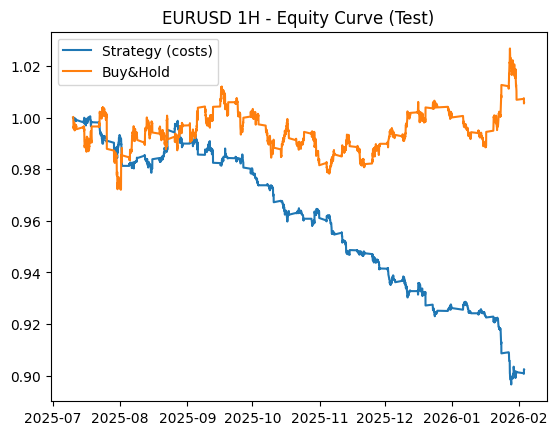

In [13]:
plt.figure()
plt.plot(bt.index, bt["equity"], label="Strategy (costs)")
plt.plot(bt.index, bt["buy_hold"], label="Buy&Hold")
plt.legend()
plt.title("EURUSD 1H - Equity Curve (Test)")
plt.show()


## 7) Métricas de trading (CAGR aprox, Max Drawdown, Sharpe aprox)

In [15]:
import numpy as np

def max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = equity / peak - 1
    return dd.min()

def sharpe_approx(returns: pd.Series, periods_per_year: int = 252*24) -> float:
    # para 1H aprox 24*252 = 6048 (si operas días hábiles)
    mu = returns.mean()
    sd = returns.std()
    if sd == 0:
        return np.nan
    return (mu / sd) * np.sqrt(periods_per_year)

eq = bt["equity"]
rets = bt["strategy_ret"]

mdd = max_drawdown(eq)
sh = sharpe_approx(rets)

print("Final equity:", float(eq.iloc[-1]))
print("Max Drawdown:", float(mdd))
print("Sharpe approx:", float(sh))
print("Trades:", int(bt["trade"].sum()))


Final equity: 0.9024112713073843
Max Drawdown: -0.10397760579034765
Sharpe approx: -5.368081818130582
Trades: 1196
